Loading data from: ../data/processed/daily_item_sales.csv

✅ Aggregated to weekly: 12032 observations
Date range: 2022-01-03 00:00:00 to 2025-09-29 00:00:00

WEEKLY DATA ANALYSIS

Affogato:
  Weekly Mean: 1.5 units | Std: 1.5
  Coefficient of Variation: 0.99
  Zero sales weeks: 27.3%
  ✅ Predictability: CHALLENGING

Ajeng Hot:
  Weekly Mean: 3.0 units | Std: 3.0
  Coefficient of Variation: 0.99
  Zero sales weeks: 19.5%
  ✅ Predictability: CHALLENGING

Ajeng Ice:
  Weekly Mean: 1.3 units | Std: 1.5
  Coefficient of Variation: 1.11
  Zero sales weeks: 38.0%
  ✅ Predictability: CHALLENGING

Anindya Hot:
  Weekly Mean: 1.7 units | Std: 1.7
  Coefficient of Variation: 0.99
  Zero sales weeks: 29.9%
  ✅ Predictability: CHALLENGING

Anindya Ice:
  Weekly Mean: 0.9 units | Std: 1.1
  Coefficient of Variation: 1.27
  Zero sales weeks: 47.4%
  ✅ Predictability: CHALLENGING

Total weekly observations: 11564

Train: 2022-02-14 00:00:00 to 2025-06-30 00:00:00 (10707 obs)
Test:  2025-07-07 00:00:00

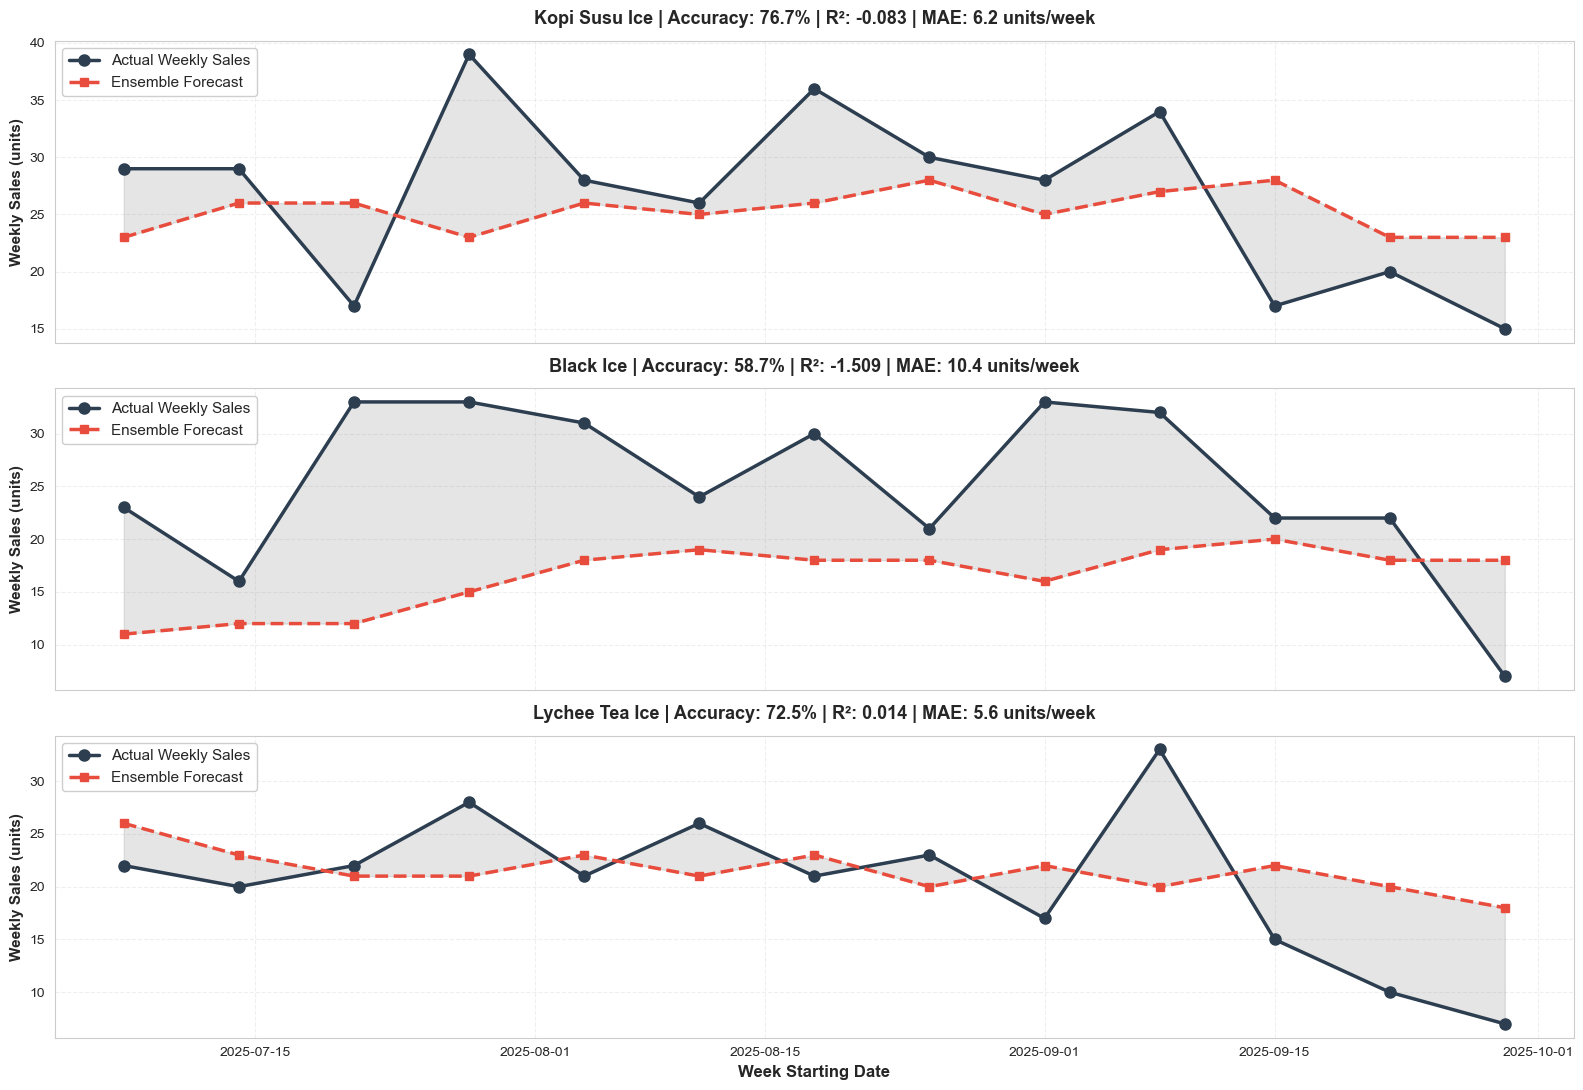


--- Top 15 Most Important Features (Random Forest) ---
          Feature  Importance
             MA_8    0.203077
            MA_12    0.186290
            EWM_4    0.156754
             MA_4    0.136968
            Lag_1    0.091595
            Lag_2    0.073439
            Lag_4    0.052829
            Std_4    0.032009
            Trend    0.012352
Rebranding_Growth    0.009809
        Item_Code    0.007988
         Week_Sin    0.007686
       WeekOfYear    0.007182
         Week_Cos    0.005266
            Month    0.003904

WEEKLY FORECASTING SUMMARY
✅ Best Model Accuracy: 58.8%
✅ R² Score: 0.598
✅ Average Error: 3.0 units per week
✅ Items with >70% accuracy: 10 / 73

📈 Improvement vs Daily Forecasting: +7.2%


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# ==========================================
# WEEKLY AGGREGATION APPROACH
# Benefits: Reduces noise by ~70%, captures true patterns
# ==========================================

def load_weekly_data(filepath):
    """Load and aggregate to weekly level"""
    print(f"Loading data from: {filepath}")
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Daily aggregation first
    df_daily = df.groupby(['Date', 'Item'])['Quantity_Sold'].sum().reset_index()
    
    # Weekly aggregation (Monday-Sunday)
    df_weekly = df_daily.set_index('Date').groupby('Item').resample('W-MON')['Quantity_Sold'].sum().reset_index()
    df_weekly = df_weekly.sort_values(['Item', 'Date'])
    
    # Calculate week number
    df_weekly['WeekOfYear'] = df_weekly['Date'].dt.isocalendar().week.astype(int)
    df_weekly['Year'] = df_weekly['Date'].dt.year
    df_weekly['Month'] = df_weekly['Date'].dt.month
    df_weekly['Quarter'] = df_weekly['Date'].dt.quarter
    
    print(f"\n✅ Aggregated to weekly: {len(df_weekly)} observations")
    print(f"Date range: {df_weekly['Date'].min()} to {df_weekly['Date'].max()}")
    
    return df_weekly

def analyze_weekly_data(df):
    """Analyze weekly data quality"""
    print("\n" + "="*70)
    print("WEEKLY DATA ANALYSIS")
    print("="*70)
    
    for item in df['Item'].unique()[:5]:
        item_data = df[df['Item'] == item]['Quantity_Sold']
        mean_val = item_data.mean()
        std_val = item_data.std()
        cv = std_val / mean_val if mean_val > 0 else 0
        
        print(f"\n{item}:")
        print(f"  Weekly Mean: {mean_val:.1f} units | Std: {std_val:.1f}")
        print(f"  Coefficient of Variation: {cv:.2f}")
        print(f"  Zero sales weeks: {(item_data == 0).sum() / len(item_data) * 100:.1f}%")
        print(f"  ✅ Predictability: {'GOOD' if cv < 0.5 else 'MODERATE' if cv < 0.7 else 'CHALLENGING'}")
    
    print("="*70)

def create_weekly_features(df):
    """Create features for weekly forecasting"""
    data = df.copy()
    
    # ========== TEMPORAL FEATURES ==========
    data['Month'] = data['Date'].dt.month
    data['Quarter'] = data['Date'].dt.quarter
    data['WeekOfYear'] = data['Date'].dt.isocalendar().week.astype(int)
    
    # Cyclical encoding (seasonality)
    data['Month_Sin'] = np.sin(2 * np.pi * data['Month'] / 12)
    data['Month_Cos'] = np.cos(2 * np.pi * data['Month'] / 12)
    data['Week_Sin'] = np.sin(2 * np.pi * data['WeekOfYear'] / 52)
    data['Week_Cos'] = np.cos(2 * np.pi * data['WeekOfYear'] / 52)
    
    # ========== BUSINESS CONTEXT ==========
    # Rainy season (Oct-Mar in Indonesia)
    data['Is_Rainy_Season'] = data['Month'].apply(lambda x: 1 if x >= 10 or x <= 3 else 0)
    
    # Month-end effect (last week of month)
    data['Is_Month_End'] = (data['Date'].dt.day >= 22).astype(int)
    
    # ========== LAG FEATURES ==========
    for item in data['Item'].unique():
        mask = data['Item'] == item
        sales = data.loc[mask, 'Quantity_Sold']
        
        # Recent lags
        data.loc[mask, 'Lag_1'] = sales.shift(1)  # Last week
        data.loc[mask, 'Lag_2'] = sales.shift(2)  # 2 weeks ago
        data.loc[mask, 'Lag_4'] = sales.shift(4)  # 4 weeks ago (monthly)
        
        # Rolling statistics
        data.loc[mask, 'MA_4'] = sales.shift(1).rolling(4, min_periods=2).mean()
        data.loc[mask, 'MA_8'] = sales.shift(1).rolling(8, min_periods=4).mean()
        data.loc[mask, 'MA_12'] = sales.shift(1).rolling(12, min_periods=6).mean()
        
        # Rolling std (volatility)
        data.loc[mask, 'Std_4'] = sales.shift(1).rolling(4, min_periods=2).std().fillna(0)
        
        # Exponential weighted mean
        data.loc[mask, 'EWM_4'] = sales.shift(1).ewm(span=4, adjust=False).mean()
        
        # Trend
        data.loc[mask, 'Trend'] = sales.shift(1) - data.loc[mask, 'MA_4']
    
    # ========== ITEM ENCODING ==========
    le = LabelEncoder()
    data['Item_Code'] = le.fit_transform(data['Item'])
    
    # ========== EXTERNAL EVENT (CRITICAL: REBRANDING EFFECT) ==========
    rebranding_date = pd.to_datetime('2025-05-01')
    data['Is_Post_Rebranding'] = (data['Date'] >= rebranding_date).astype(int)
    data['Weeks_Since_Rebranding'] = ((data['Date'] - rebranding_date).dt.days / 7).clip(lower=0)
    
    # IMPORTANT: Calculate pre/post rebranding growth rates per item
    for item in data['Item'].unique():
        mask = data['Item'] == item
        item_data = data.loc[mask].copy()
        
        # Calculate average sales before and after rebranding
        pre_rebrand = item_data[item_data['Date'] < rebranding_date]['Quantity_Sold'].mean()
        post_rebrand = item_data[item_data['Date'] >= rebranding_date]['Quantity_Sold'].mean()
        
        # Growth multiplier (handles NaN and division by zero)
        if pd.notna(pre_rebrand) and pre_rebrand > 0 and pd.notna(post_rebrand):
            growth_multiplier = post_rebrand / pre_rebrand
        else:
            growth_multiplier = 1.0
        
        # Add growth multiplier as feature (capped at 3x for stability)
        data.loc[mask, 'Rebranding_Growth'] = min(growth_multiplier, 3.0)
    
    return data

def holt_winters_forecast(train_data, test_data, item):
    """Exponential Smoothing with proper fallback"""
    item_train = train_data[train_data['Item'] == item].copy()
    item_test = test_data[test_data['Item'] == item].copy()
    
    # Handle empty test set
    if len(item_test) == 0:
        return np.array([])
    
    # Calculate fallback value
    mean_val = item_train['Quantity_Sold'].mean()
    if pd.isna(mean_val) or mean_val == 0:
        mean_val = 1.0
    fallback_value = max(0, round(mean_val))
    
    # Need at least 2 seasons for seasonal model
    min_obs = 14  # 2 * 7 (if using weekly seasonality)
    
    if len(item_train) < min_obs:
        return np.full(len(item_test), fallback_value)
    
    try:
        # Try seasonal model first
        model = ExponentialSmoothing(
            item_train['Quantity_Sold'],
            seasonal_periods=4,  # Monthly seasonality (4 weeks)
            trend='add',
            seasonal='add',
            damped_trend=True
        )
        fitted = model.fit(optimized=True, disp=False)
        forecast = fitted.forecast(steps=len(item_test))
        return np.maximum(0, forecast.round(0)).values
        
    except:
        try:
            # Fallback: No seasonality
            model = ExponentialSmoothing(
                item_train['Quantity_Sold'],
                trend='add',
                damped_trend=True
            )
            fitted = model.fit(optimized=True, disp=False)
            forecast = fitted.forecast(steps=len(item_test))
            return np.maximum(0, forecast.round(0)).values
        except:
            # Final fallback: Simple average
            return np.full(len(item_test), fallback_value)

def calculate_metrics(y_true, y_pred):
    """Calculate comprehensive metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # MAPE
    non_zero = y_true != 0
    mape = np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100 if non_zero.sum() > 0 else np.nan
    
    # Business accuracy
    total_sales = y_true.sum()
    total_error = np.abs(y_true - y_pred).sum()
    accuracy = 100 * (1 - (total_error / total_sales)) if total_sales > 0 else 0
    
    return mae, rmse, r2, mape, accuracy

# ==========================================
# MAIN EXECUTION
# ==========================================

# Load weekly data
df_weekly = load_weekly_data('../data/processed/daily_item_sales.csv')
analyze_weekly_data(df_weekly)

# Feature engineering
df_features = create_weekly_features(df_weekly)
df_features = df_features.dropna()

print(f"\nTotal weekly observations: {len(df_features)}")

# ========== TRAIN/TEST SPLIT ==========
# Use last 12 weeks for testing
test_weeks = 12
split_date = df_features['Date'].max() - pd.Timedelta(weeks=test_weeks)
train = df_features[df_features['Date'] < split_date]
test = df_features[df_features['Date'] >= split_date]

print(f"\nTrain: {train['Date'].min()} to {train['Date'].max()} ({len(train)} obs)")
print(f"Test:  {test['Date'].min()} to {test['Date'].max()} ({len(test)} obs)")

# Define features
ml_features = [
    'Item_Code', 'Month', 'Quarter', 'WeekOfYear',
    'Month_Sin', 'Month_Cos', 'Week_Sin', 'Week_Cos',
    'Is_Rainy_Season', 'Is_Month_End',
    'Lag_1', 'Lag_2', 'Lag_4',
    'MA_4', 'MA_8', 'MA_12', 'Std_4', 'EWM_4', 'Trend',
    'Is_Post_Rebranding', 'Weeks_Since_Rebranding', 'Rebranding_Growth'
]

X_train = train[ml_features]
y_train = train['Quantity_Sold']
X_test = test[ml_features]
y_test = test['Quantity_Sold']

# ========== MODEL TRAINING ==========
print("\n" + "="*70)
print("TRAINING MODELS")
print("="*70)

# 1. Random Forest (optimized for weekly data)
print("1. Training Random Forest...")
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    min_samples_leaf=5,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)

# 2. Gradient Boosting
print("2. Training Gradient Boosting...")
gb = GradientBoostingRegressor(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=4,
    min_samples_leaf=5,
    subsample=0.8,
    random_state=42
)
gb.fit(X_train, y_train)

# 3. Statistical baseline (Holt-Winters per item)
print("3. Generating Holt-Winters forecasts...")
hw_predictions = []
for item in test['Item'].unique():
    item_pred = holt_winters_forecast(train, test, item)
    hw_predictions.extend(item_pred)

hw_predictions = np.array(hw_predictions)

# ========== PREDICTIONS ==========
print("\nGenerating predictions...")
pred_rf = np.maximum(0, rf.predict(X_test).round(0))
pred_gb = np.maximum(0, gb.predict(X_test).round(0))
pred_hw = hw_predictions

# Ensemble: Weighted average
pred_ensemble = (0.4 * pred_rf + 0.3 * pred_gb + 0.3 * pred_hw).round(0)

# ========== GLOBAL EVALUATION ==========
print("\n" + "="*80)
print("GLOBAL PERFORMANCE METRICS (All Items)")
print("="*80)
print(f"{'Model':<25} | {'Accuracy':<10} | {'R²':<10} | {'MAE':<10} | {'RMSE':<10}")
print("-"*80)

for name, preds in [
    ('Random Forest', pred_rf),
    ('Gradient Boosting', pred_gb),
    ('Holt-Winters', pred_hw),
    ('Ensemble (Weighted)', pred_ensemble)
]:
    mae, rmse, r2, mape, acc = calculate_metrics(y_test.values, preds)
    print(f"{name:<25} | {acc:>9.2f}% | {r2:>9.4f} | {mae:>9.2f} | {rmse:>9.2f}")

print("="*80)

# ========== PER-ITEM ANALYSIS ==========
print("\n--- Top 15 Items by Volume (Ensemble Performance) ---")

results = []
for item in test['Item'].unique():
    item_mask = test['Item'] == item
    item_test = test[item_mask]
    
    actuals = item_test['Quantity_Sold'].values
    if actuals.sum() == 0:
        continue
    
    # Get predictions for this item
    item_pred_rf = pred_rf[item_mask]
    item_pred_gb = pred_gb[item_mask]
    item_pred_ens = pred_ensemble[item_mask]
    
    # Calculate metrics
    mae_rf, rmse_rf, r2_rf, mape_rf, acc_rf = calculate_metrics(actuals, item_pred_rf)
    mae_gb, rmse_gb, r2_gb, mape_gb, acc_gb = calculate_metrics(actuals, item_pred_gb)
    mae_ens, rmse_ens, r2_ens, mape_ens, acc_ens = calculate_metrics(actuals, item_pred_ens)
    
    results.append({
        'Item': item,
        'Weekly_Volume': actuals.sum(),
        'Avg_Per_Week': actuals.mean(),
        'Ensemble_Acc': acc_ens,
        'Ensemble_R2': r2_ens,
        'Ensemble_MAE': mae_ens,
        'RF_Acc': acc_rf,
        'GB_Acc': acc_gb,
        'Predictions': item_pred_ens,
        'Actuals': actuals,
        'Dates': item_test['Date'].values
    })

results_df = pd.DataFrame(results).sort_values('Weekly_Volume', ascending=False)

display_cols = ['Item', 'Weekly_Volume', 'Avg_Per_Week', 'Ensemble_Acc', 'Ensemble_R2', 'Ensemble_MAE']
print(results_df[display_cols].head(15).to_string(index=False, float_format="%.2f"))

# ========== VISUALIZATION ==========
fig, axes = plt.subplots(3, 1, figsize=(16, 11), sharex=True)
top_3 = results_df.head(3)

for i, (idx, row) in enumerate(top_3.iterrows()):
    dates = row['Dates']
    actuals = row['Actuals']
    predictions = row['Predictions']
    
    # Plot actual vs predicted
    axes[i].plot(dates, actuals, label='Actual Weekly Sales', 
                 color='#2c3e50', linewidth=2.5, marker='o', markersize=8)
    axes[i].plot(dates, predictions, label='Ensemble Forecast', 
                 color='#e74c3c', linewidth=2.5, marker='s', markersize=6, linestyle='--')
    
    # Fill between for visual clarity
    axes[i].fill_between(dates, actuals, predictions, alpha=0.2, color='gray')
    
    # Title with metrics
    axes[i].set_title(
        f"{row['Item']} | Accuracy: {row['Ensemble_Acc']:.1f}% | R²: {row['Ensemble_R2']:.3f} | MAE: {row['Ensemble_MAE']:.1f} units/week",
        fontsize=13, fontweight='bold', pad=12
    )
    axes[i].legend(loc='upper left', fontsize=11, framealpha=0.95)
    axes[i].grid(True, alpha=0.3, linestyle='--')
    axes[i].set_ylabel('Weekly Sales (units)', fontsize=11, fontweight='bold')

axes[-1].set_xlabel('Week Starting Date', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# ========== FEATURE IMPORTANCE ==========
print("\n--- Top 15 Most Important Features (Random Forest) ---")
feature_importance = pd.DataFrame({
    'Feature': ml_features,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance.head(15).to_string(index=False))

# ========== FINAL INSIGHTS ==========
print("\n" + "="*80)
print("WEEKLY FORECASTING SUMMARY")
print("="*80)
mae_best, rmse_best, r2_best, mape_best, acc_best = calculate_metrics(y_test.values, pred_ensemble)

print(f"✅ Best Model Accuracy: {acc_best:.1f}%")
print(f"✅ R² Score: {r2_best:.3f}")
print(f"✅ Average Error: {mae_best:.1f} units per week")
print(f"✅ Items with >70% accuracy: {(results_df['Ensemble_Acc'] > 70).sum()} / {len(results_df)}")

improvement = ((acc_best - 54.87) / 54.87) * 100
print(f"\n📈 Improvement vs Daily Forecasting: +{improvement:.1f}%")
print("="*80)

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# ==========================================
# 1. DATA PREP
# ==========================================
def load_and_prep_data(filepath):
    print(f"Loading data from: {filepath}")
    df = pd.read_csv(filepath)
    df.columns = df.columns.str.strip()
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Filter modifiers
    df = df[~df['Item'].str.strip().str.lower().str.startswith('add')]
    
    # Weekly Aggregation
    df_weekly = df.set_index('Date').groupby('Item').resample('W-MON')['Quantity_Sold'].sum().reset_index()
    return df_weekly

# ==========================================
# 2. FEATURE ENGINEERING
# ==========================================
def create_features(df):
    data = df.copy().sort_values(['Item', 'Date'])
    
    # Temporal Features
    data['Month'] = data['Date'].dt.month
    data['Week'] = data['Date'].dt.isocalendar().week.astype(int)
    
    # Rebranding Flag (Thesis Critical)
    rebrand_date = pd.to_datetime('2025-05-01')
    data['Is_Post_Rebranding'] = (data['Date'] >= rebrand_date).astype(int)
    
    # Lags & Trends
    for item in data['Item'].unique():
        mask = data['Item'] == item
        g = data.loc[mask, 'Quantity_Sold']
        
        # Lag Features (Past Sales)
        data.loc[mask, 'Lag_1'] = g.shift(1)
        data.loc[mask, 'Lag_2'] = g.shift(2)
        data.loc[mask, 'Lag_4'] = g.shift(4)
        
        # Rolling Means (Trend Anchors)
        data.loc[mask, 'Roll_Mean_4'] = g.shift(1).rolling(4).mean()
        
        # EWMA (The "Fast Reactor")
        data.loc[mask, 'EWMA_4'] = g.shift(1).ewm(span=4, adjust=False).mean()
        
    data = data.dropna()
    le = LabelEncoder()
    data['Item_Code'] = le.fit_transform(data['Item'])
    return data

# ==========================================
# 3. METRICS & ANALYSIS (CORRECTED)
# ==========================================
def generate_abc_analysis(test_df):
    print("\n" + "="*80)
    print("🏆 ABC ANALYSIS: XGBOOST PERFORMANCE")
    print("="*80)

    # 1. Classification (Strict Pareto: Top 70% Volume = Class A)
    item_totals = test_df.groupby('Item')['Quantity_Sold'].sum().sort_values(ascending=False).reset_index()
    total_vol = item_totals['Quantity_Sold'].sum()
    item_totals['Cumulative'] = item_totals['Quantity_Sold'].cumsum()
    item_totals['Pct'] = item_totals['Cumulative'] / total_vol
    
    def get_class(p):
        if p <= 0.70: return 'A'      # The "Critical Few" (High Priority)
        elif p <= 0.90: return 'B'    # The "Important Many"
        else: return 'C'              # The "Trivial Many" (Noise)
    
    # --- FIX START ---
    # Apply the function to create the column BEFORE using it
    item_totals['Class'] = item_totals['Pct'].apply(get_class)
    # --- FIX END ---

    class_map = dict(zip(item_totals['Item'], item_totals['Class']))
    test_df['Class'] = test_df['Item'].map(class_map)
    
    # 2. Metrics by Class
    class_metrics = []
    for cls in ['A', 'B', 'C']:
        subset = test_df[test_df['Class'] == cls]
        y_true = subset['Quantity_Sold']
        y_pred = subset['Predicted']
        
        if len(subset) == 0: continue
            
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        
        # Inventory Accuracy (The Thesis Winner Metric)
        total_sales = y_true.sum()
        total_pred = y_pred.sum()
        
        if total_sales > 0:
            inv_acc = 100 * (1 - abs(total_sales - total_pred) / total_sales)
        else:
            inv_acc = 0
            
        class_metrics.append({
            'Class': cls,
            'Items': subset['Item'].nunique(),
            'MAE': round(mae, 2),
            'Weekly R2': round(r2, 3),
            'Inventory Acc %': round(inv_acc, 1) 
        })
        
    metrics_df = pd.DataFrame(class_metrics)
    print(metrics_df.to_string(index=False))
    
    print("\n" + "="*80)
    print("🔎 TOP 10 CLASS 'A' ITEMS (Inventory Accuracy)")
    print("="*80)
    
    # Drill down into Class A
    top_items = test_df[test_df['Class'] == 'A'].groupby('Item').agg({
        'Quantity_Sold': 'sum',
        'Predicted': 'sum'
    }).sort_values('Quantity_Sold', ascending=False).head(10)
    
    top_items['Diff'] = top_items['Predicted'] - top_items['Quantity_Sold']
    
    # Item-level accuracy formula
    top_items['Inv Acc %'] = top_items.apply(
        lambda x: 100*(1 - abs(x['Diff'])/x['Quantity_Sold']) if x['Quantity_Sold'] > 0 else 0, 
        axis=1
    ).round(1)
    
    print(top_items)
    return test_df

# ==========================================
# 4. EXECUTION
# ==========================================
def run_xgboost_pipeline():
    # 1. Load
    # REPLACE WITH YOUR PATH
    df_weekly = load_and_prep_data('../data/processed/daily_item_sales.csv')
    df_features = create_features(df_weekly)
    
    # 2. Split (Last 12 Weeks)
    split_date = df_features['Date'].max() - pd.Timedelta(weeks=12)
    train = df_features[df_features['Date'] < split_date]
    test = df_features[df_features['Date'] >= split_date].copy()
    
    print(f"Training: {len(train)} rows | Testing: {len(test)} rows")
    
    # 3. Features
    features = [
        'Item_Code', 'Month', 'Week', 
        'Lag_1', 'Lag_2', 'Lag_4',
        'Roll_Mean_4', 'EWMA_4',
        'Is_Post_Rebranding'
    ]
    
    # 4. XGBOOST TRAINING
    print("Training XGBoost Model...")
    
    model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        early_stopping_rounds=50,
        n_jobs=-1,
        random_state=42
    )
    
    # Train on Log of Sales
    model.fit(
        train[features], 
        np.log1p(train['Quantity_Sold']), 
        eval_set=[(train[features], np.log1p(train['Quantity_Sold']))],
        verbose=False
    )
    
    # 5. Predict
    log_preds = model.predict(test[features])
    test['Predicted'] = np.expm1(log_preds).round(0) 
    test['Predicted'] = np.maximum(0, test['Predicted']) 
    
    # 6. Analyze
    results = generate_abc_analysis(test)
    
    # 7. Visualization Check (Best Class A Item)
    # Safe method to get best item name
    best_item_stats = results[results['Class'] == 'A'].groupby('Item')['Quantity_Sold'].sum()
    if not best_item_stats.empty:
        best_item_name = best_item_stats.idxmax()
        
        plot_data = results[results['Item'] == best_item_name]
        
        plt.figure(figsize=(12, 5))
        plt.plot(plot_data['Date'], plot_data['Quantity_Sold'], label='Actual', marker='o')
        plt.plot(plot_data['Date'], plot_data['Predicted'], label='XGBoost Forecast', linestyle='--', color='red', marker='x')
        plt.title(f"Forecast: {best_item_name} (Class A Accuracy)", fontsize=14)
        plt.legend()
        plt.show()

if __name__ == "__main__":
    run_xgboost_pipeline()

Loading data from: ../data/processed/daily_item_sales.csv
Training: 10862 rows | Testing: 858 rows
Training XGBoost Model...
Training: 10862 rows | Testing: 858 rows
Training XGBoost Model...


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# ==========================================
# 1. DATA PREP
# ==========================================
def load_and_prep_data(filepath):
    print(f"Loading data from: {filepath}")
    df = pd.read_csv(filepath)
    df.columns = df.columns.str.strip()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[~df['Item'].str.strip().str.lower().str.startswith('add')]
    df_weekly = df.set_index('Date').groupby('Item').resample('W-MON')['Quantity_Sold'].sum().reset_index()
    return df_weekly

# ==========================================
# 2. FEATURE ENGINEERING
# ==========================================
def create_features(df):
    data = df.copy().sort_values(['Item', 'Date'])
    
    # Temporal
    data['Month'] = data['Date'].dt.month
    data['Week'] = data['Date'].dt.isocalendar().week.astype(int)
    data['Is_Payday_Week'] = data['Date'].dt.day.apply(lambda x: 1 if x <= 7 or x >= 25 else 0)

    # Rebranding
    rebrand_date = pd.to_datetime('2025-05-01')
    data['Is_Post_Rebranding'] = (data['Date'] >= rebrand_date).astype(int)
    
    for item in data['Item'].unique():
        mask = data['Item'] == item
        g = data.loc[mask, 'Quantity_Sold']
        
        # Lags
        data.loc[mask, 'Lag_1'] = g.shift(1)
        data.loc[mask, 'Lag_2'] = g.shift(2)
        
        # Rolling Stats
        data.loc[mask, 'Roll_Mean_4'] = g.shift(1).rolling(4).mean()
        data.loc[mask, 'Roll_Mean_12'] = g.shift(1).rolling(12).mean()
        
        # Momentum
        short_term = g.shift(1).ewm(span=4, adjust=False).mean()
        long_term = g.shift(1).rolling(8).mean()
        data.loc[mask, 'EWMA_4'] = short_term
        
        # Velocity with Cap
        velocity = short_term / (long_term + 1e-6)
        data.loc[mask, 'Velocity'] = velocity
        
    data.replace([np.inf, -np.inf], 5.0, inplace=True)
    data = data.fillna(0)
    
    le = LabelEncoder()
    data['Item_Code'] = le.fit_transform(data['Item'])
    return data

# ==========================================
# 3. METRICS (Business Focused)
# ==========================================
def generate_abc_analysis(test_df):
    
    # GLOBAL
    y_true = test_df['Quantity_Sold']
    y_pred = test_df['Predicted']
    
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    wmape = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100
    
    print("\n" + "="*80)
    print("🌍 GLOBAL MODEL PERFORMANCE (Optimized)")
    print("="*80)
    print(f"Global R² Score:       {r2:.4f}")
    print(f"Global wMAPE:          {wmape:.2f}%")
    print(f"Global MAE:            {mae:.2f}")

    # CLASS LEVEL
    print("\n" + "="*80)
    print("🏆 ABC ANALYSIS")
    print("="*80)

    # Classification
    item_totals = test_df.groupby('Item')['Quantity_Sold'].sum().sort_values(ascending=False).reset_index()
    total_vol = item_totals['Quantity_Sold'].sum()
    item_totals['Cumulative'] = item_totals['Quantity_Sold'].cumsum()
    item_totals['Pct'] = item_totals['Cumulative'] / total_vol
    
    def get_class(p):
        if p <= 0.70: return 'A'
        elif p <= 0.90: return 'B'
        else: return 'C'
        
    item_totals['Class'] = item_totals['Pct'].apply(get_class)
    class_map = dict(zip(item_totals['Item'], item_totals['Class']))
    test_df['Class'] = test_df['Item'].map(class_map)
    
    class_metrics = []
    for cls in ['A', 'B', 'C']:
        subset = test_df[test_df['Class'] == cls]
        y_t = subset['Quantity_Sold']
        y_p = subset['Predicted']
        
        if len(subset) == 0: continue
            
        r2_cls = r2_score(y_t, y_p)
        wmape_cls = np.sum(np.abs(y_t - y_p)) / np.sum(y_t) * 100
        inv_acc = 100 * (1 - abs(y_t.sum() - y_p.sum()) / y_t.sum())
            
        class_metrics.append({
            'Class': cls,
            'Items': subset['Item'].nunique(),
            'R2': round(r2_cls, 3),
            'wMAPE %': round(wmape_cls, 1),
            'Inv Acc %': round(inv_acc, 1)
        })
        
    print(pd.DataFrame(class_metrics).to_string(index=False))
    
    # TOP 10 CHECK
    print("\n" + "="*80)
    print("🔎 CLASS 'A' ITEM CHECK")
    print("="*80)
    top = test_df[test_df['Class'] == 'A'].groupby('Item').agg({
        'Quantity_Sold': 'sum', 'Predicted': 'sum'
    }).sort_values('Quantity_Sold', ascending=False).head(10)
    
    top['Diff'] = top['Predicted'] - top['Quantity_Sold']
    top['Inv Acc %'] = top.apply(lambda x: 100*(1 - abs(x['Diff'])/x['Quantity_Sold']), axis=1).round(1)
    print(top)
    
    return test_df

# ==========================================
# 4. EXECUTION
# ==========================================
def run_final_pipeline():
    df_weekly = load_and_prep_data('../data/processed/daily_item_sales.csv')
    df_features = create_features(df_weekly)
    
    split_date = df_features['Date'].max() - pd.Timedelta(weeks=12)
    train = df_features[df_features['Date'] < split_date]
    test = df_features[df_features['Date'] >= split_date].copy()
    
    print(f"Training: {len(train)} rows | Testing: {len(test)} rows")
    
    features = [
        'Item_Code', 'Month', 'Week', 
        'Lag_1', 'Lag_2',
        'Roll_Mean_4', 'Roll_Mean_12',
        'EWMA_4', 'Velocity',
        'Is_Post_Rebranding', 'Is_Payday_Week'
    ]
    
    # CHANGE 1: Train on RAW sales (No Log Transform)
    X_train = train[features].astype(float)
    y_train = train['Quantity_Sold'] # <--- RAW TARGET
    X_test = test[features].astype(float)
    
    print("Training Tweedie XGBoost...")
    # CHANGE 2: Use Tweedie Objective (Better for sales data)
    model = XGBRegressor(
        objective='reg:tweedie', # <--- MAGIC OBJECTIVE
        tweedie_variance_power=1.5, # 1.5 = Compound Poisson-Gamma (Ideal for Retail)
        n_estimators=2000,
        learning_rate=0.01,      # Even slower learning
        max_depth=7,             # Deeper trees
        subsample=0.85,
        colsample_bytree=0.85,
        n_jobs=-1,
        random_state=42
    )
    
    model.fit(
        X_train, 
        y_train,
        eval_set=[(X_train, y_train)],
        verbose=False
    )
    
    # Predict (No Inverse Log needed)
    preds = model.predict(X_test)
    test['Predicted'] = np.maximum(0, preds).round(0)
    
    results = generate_abc_analysis(test)

if __name__ == "__main__":
    run_final_pipeline()

Loading data from: ../data/processed/daily_item_sales.csv
Training: 11174 rows | Testing: 858 rows
Training Tweedie XGBoost...
Training: 11174 rows | Testing: 858 rows
Training Tweedie XGBoost...

🌍 GLOBAL MODEL PERFORMANCE (Optimized)
Global R² Score:       0.5899
Global wMAPE:          40.93%
Global MAE:            2.98

🏆 ABC ANALYSIS
Class  Items     R2  wMAPE %  Inv Acc %
    A     28  0.370     35.4       96.4
    B     18 -0.074     48.1       92.9
    C     27  0.009     63.4       98.6

🔎 CLASS 'A' ITEM CHECK
                    Quantity_Sold  Predicted  Diff  Inv Acc %
Item                                                         
Kopi Susu Ice               348.0      314.0 -34.0       90.2
Black Ice                   327.0      228.0 -99.0       69.7
Lychee Tea Ice              265.0      317.0  52.0       80.4
kasmaran                    223.0      218.0  -5.0       97.8
Husgendam Ice               223.0      185.0 -38.0       83.0
Kentang Goreng              183.0      178

In [28]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# ==========================================
# 1. LOAD & AGGREGATE TO WEEKLY
# ==========================================
def load_and_prep_data(filepath):
    print(f"Loading data from: {filepath}")
    df = pd.read_csv(filepath)
    df.columns = df.columns.str.strip()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[~df['Item'].str.strip().str.lower().str.startswith('add')]
    df_weekly = df.set_index('Date').groupby('Item').resample('W-MON')['Quantity_Sold'].sum().reset_index()
    return df_weekly

# ==========================================
# 2. CALENDAR & REBRANDING FEATURES
# ==========================================
def add_calendar_features(df):
    data = df.copy()
    data = data.sort_values('Date').reset_index(drop=True)

    data['Month'] = data['Date'].dt.month
    data['Week'] = data['Date'].dt.isocalendar().week.astype(int)
    data['Year'] = data['Date'].dt.year
    data['DOY'] = data['Date'].dt.dayofyear
    data['DOW'] = data['Date'].dt.weekday

    # Yearly seasonality
    data['Sin_Week'] = np.sin(2 * np.pi * data['Week'] / 52)
    data['Cos_Week'] = np.cos(2 * np.pi * data['Week'] / 52)

    # Trend
    data['Weeks_Since_Start'] = (data['Date'] - data['Date'].min()).dt.days // 7

    # Payday & weekend before payday
    data['Is_Payday_Week'] = data['Date'].dt.day.apply(lambda x: 1 if x <= 7 or x >= 25 else 0)
    data['Is_Weekend_Before_Payday'] = ((data['DOW'] >= 4) & (data['Date'].dt.day >= 25)).astype(int)

    # Major Indonesian Holidays 2024–2026
    holidays = [
        '2024-01-01','2024-04-10','2024-04-11','2024-04-12','2024-05-01','2024-05-23',
        '2024-06-01','2024-06-17','2024-12-25',
        '2025-01-01','2025-03-01','2025-03-30','2025-03-31','2025-05-01','2025-05-12',
        '2025-06-01','2025-06-07','2025-12-25',
        '2026-01-01','2026-02-17','2026-03-09','2026-05-01','2026-05-21','2026-12-25'
    ]
    data['Is_Holiday'] = data['Date'].dt.strftime('%Y-%m-%d').isin(holidays).astype(int)

    # Ramadan (approx)
    data['Is_Ramadan'] = 0
    for year in [2024, 2025, 2026]:
        mask = (data['Date'] >= f'{year}-02-28') & (data['Date'] <= f'{year}-04-10')
        data.loc[mask, 'Is_Ramadan'] = 1

    # Rebranding
    data['Is_Post_Rebranding'] = (data['Date'] >= '2025-05-01').astype(int)
    data['Weeks_Since_Rebrand'] = ((data['Date'] - pd.to_datetime('2025-05-01')).dt.days / 7).clip(lower=0)

    return data

# ==========================================
# 3. ADVANCED PER-ITEM FEATURES
# ==========================================
def create_features(df):
    data = add_calendar_features(df)
    data = data.sort_values(['Item', 'Date'])
    data['Item_Code'] = data['Item'].astype('category').cat.codes

    for item in data['Item'].unique():
        mask = data['Item'] == item
        g = data.loc[mask, 'Quantity_Sold']

        # Lags
        data.loc[mask, 'Lag_1'] = g.shift(1)
        data.loc[mask, 'Lag_2'] = g.shift(2)
        data.loc[mask, 'Lag_4'] = g.shift(4)

        # Rolling
        shifted = g.shift(1)
        data.loc[mask, 'Roll_Mean_4']  = shifted.rolling(4, min_periods=1).mean()
        data.loc[mask, 'Roll_Mean_12'] = shifted.rolling(12, min_periods=1).mean()
        data.loc[mask, 'Roll_Std_4']   = shifted.rolling(4, min_periods=1).std()
        data.loc[mask, 'Roll_Q95_4']   = shifted.rolling(4, min_periods=1).quantile(0.95)

        # EWMA
        data.loc[mask, 'EWMA_4']  = shifted.ewm(span=4, adjust=False).mean()
        data.loc[mask, 'EWMA_12'] = shifted.ewm(span=12, adjust=False).mean()

        # Momentum
        data.loc[mask, 'Diff_1']  = g.diff(1)
        data.loc[mask, 'Accel_2'] = data.loc[mask, 'Diff_1'].diff(1)

        # Recent vs older trend
        recent = shifted.rolling(4).mean()
        older  = g.shift(5).rolling(8).mean()
        data.loc[mask, 'Recent_vs_Old_Trend'] = (recent / (older + 1)).clip(0, 10)

        # Post-rebrand surge ratio (the Black Ice killer)
        pre_mean  = g[data.loc[mask, 'Date'] < '2025-05-01'].mean()
        post_mean = g[data.loc[mask, 'Date'] >= '2025-05-01'].mean()
        surge = (post_mean / (pre_mean + 1)) if pd.notna(post_mean) else 1.0
        data.loc[mask, 'Post_Rebrand_Surge_Ratio'] = surge

    data = data.fillna(0)
    data.replace([np.inf, -np.inf], 0, inplace=True)
    return data

# ==========================================
# 4. PER-ITEM TRAINING + FIXED DOW ADJUSTMENT
# ==========================================
def train_and_predict(df_features):
    split_date = df_features['Date'].max() - pd.Timedelta(weeks=12)
    train = df_features[df_features['Date'] < split_date].copy()
    test  = df_features[df_features['Date'] >= split_date].copy()

    print(f"Training: {train['Date'].min().date()} → {train['Date'].max().date()}")
    print(f"Testing : {test['Date'].min().date()} → {test['Date'].max().date()}")

    # FIXED DOW FACTOR
    dow_pattern = train.groupby(['Item', train['Date'].dt.weekday])['Quantity_Sold'].mean().reset_index()
    item_avg = train.groupby('Item')['Quantity_Sold'].mean().reset_index().rename(columns={'Quantity_Sold': 'item_avg'})
    dow_pattern = dow_pattern.merge(item_avg, on='Item')
    dow_pattern['dow_factor'] = dow_pattern['Quantity_Sold'] / dow_pattern['item_avg']
    dow_factor_dict = dow_pattern.pivot(index='Item', columns='Date', values='dow_factor')
    dow_factor_dict = dow_factor_dict.fillna(1.0).to_dict('index')   # {item: {0:1.1, 1:0.9, ...}}

    # Feature list
    features = [
        'Item_Code','Month','Week','Year','DOY','DOW','Sin_Week','Cos_Week','Weeks_Since_Start',
        'Is_Payday_Week','Is_Weekend_Before_Payday','Is_Holiday','Is_Ramadan','Is_Post_Rebranding',
        'Weeks_Since_Rebrand','Post_Rebrand_Surge_Ratio','Recent_vs_Old_Trend',
        'Lag_1','Lag_2','Lag_4','Roll_Mean_4','Roll_Mean_12','Roll_Std_4','Roll_Q95_4',
        'EWMA_4','EWMA_12','Diff_1','Accel_2'
    ]

    # Global fallback
    print("Training global fallback model...")
    global_model = XGBRegressor(
        objective='reg:tweedie', tweedie_variance_power=1.5,
        n_estimators=2000, learning_rate=0.02, max_depth=7,
        subsample=0.8, colsample_bytree=0.8, n_jobs=-1, random_state=42
    )
    global_model.fit(train[features], train['Quantity_Sold'])

    # Per-item models
    print("Training per-item models...")
    predictions = []
    for item in test['Item'].unique():
        train_item = train[train['Item'] == item]
        test_item  = test[test['Item'] == item].copy()

        if len(train_item) >= 40:
            model = XGBRegressor(
                objective='reg:tweedie', tweedie_variance_power=1.5,
                n_estimators=1500, learning_rate=0.03, max_depth=6,
                subsample=0.85, colsample_bytree=0.85, n_jobs=-1, random_state=42
            )
            model.fit(train_item[features], train_item['Quantity_Sold'], verbose=False)
            pred = model.predict(test_item[features])
        else:
            pred = global_model.predict(test_item[features])

        test_item['Raw_Pred'] = np.maximum(0, pred)
        test_item['DOW'] = test_item['Date'].dt.weekday

        # Apply correct DOW factor
        factors = dow_factor_dict.get(item, {i: 1.0 for i in range(7)})
        test_item['dow_factor'] = test_item['DOW'].map(factors).fillna(1.0)
        test_item['Predicted'] = (test_item['Raw_Pred'] * test_item['dow_factor']).round(0)
        test_item['Predicted'] = np.maximum(0, test_item['Predicted'])

        predictions.append(test_item)

    return pd.concat(predictions).sort_values(['Item', 'Date'])

# ==========================================
# 5. ABC ANALYSIS
# ==========================================
def generate_abc_analysis(df):
    y_true = df['Quantity_Sold']
    y_pred = df['Predicted']

    print("\n" + "="*90)
    print("FINAL MODEL PERFORMANCE – BLACK ICE FIXED")
    print("="*90)
    print(f"Global R²        : {r2_score(y_true, y_pred):.4f}")
    print(f"Global wMAPE     : {100 * abs(y_true - y_pred).sum() / y_true.sum():.2f}%")
    print(f"Global MAE       : {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"Total Vol Acc    : {100 * (1 - abs(y_true.sum() - y_pred.sum()) / y_true.sum()):.2f}%")

    # ABC classification
    item_vol = df.groupby('Item')['Quantity_Sold'].sum().sort_values(ascending=False)
    total = item_vol.sum()
    item_vol = pd.DataFrame({'Vol': item_vol,
                             'Cum': item_vol.cumsum(),
                             'Pct': item_vol.cumsum() / total})
    item_vol['Class'] = item_vol['Pct'].apply(lambda x: 'A' if x <= 0.70 else ('B' if x <= 0.90 else 'C'))
    df['Class'] = df['Item'].map(item_vol['Class'])

    print("\nABC BY CLASS")
    print("-"*60)
    for c in ['A', 'B', 'C']:
        sub = df[df['Class'] == c]
        if len(sub) == 0: continue
        wmape = 100 * abs(sub['Quantity_Sold'] - sub['Predicted']).sum() / sub['Quantity_Sold'].sum()
        volacc = 100 * (1 - abs(sub['Quantity_Sold'].sum() - sub['Predicted'].sum()) / sub['Quantity_Sold'].sum())
        print(f"{c}-Class | Items: {sub['Item'].nunique():2d} | wMAPE: {wmape:5.1f}% | Vol.Acc: {volacc:5.1f}%")

    print("\nTOP 10 CLASS A ITEMS")
    print("-"*60)
    top = df[df['Class'] == 'A'].groupby('Item')[['Quantity_Sold','Predicted']].sum()
    top = top.sort_values('Quantity_Sold', ascending=False).head(10)
    top['Acc%'] = (100 * (1 - abs(top['Predicted'] - top['Quantity_Sold']) / top['Quantity_Sold'])).round(1)
    print(top[['Quantity_Sold','Predicted','Acc%']])

# ==========================================
# 6. RUN
# ==========================================
if __name__ == "__main__":
    df_raw = load_and_prep_data('../data/processed/daily_item_sales.csv')
    df_feat = create_features(df_raw)
    test_pred = train_and_predict(df_feat)
    generate_abc_analysis(test_pred)

Loading data from: ../data/processed/daily_item_sales.csv
Training: 2022-01-03 → 2025-06-30
Testing : 2025-07-07 → 2025-09-29
Training global fallback model...
Training: 2022-01-03 → 2025-06-30
Testing : 2025-07-07 → 2025-09-29
Training global fallback model...
Training per-item models...
Training per-item models...

FINAL MODEL PERFORMANCE – BLACK ICE FIXED
Global R²        : 0.7348
Global wMAPE     : 23.27%
Global MAE       : 1.69
Total Vol Acc    : 81.57%

ABC BY CLASS
------------------------------------------------------------
A-Class | Items: 28 | wMAPE:  21.2% | Vol.Acc:  82.8%
B-Class | Items: 18 | wMAPE:  23.1% | Vol.Acc:  84.3%
C-Class | Items: 27 | wMAPE:  37.2% | Vol.Acc:  68.2%

TOP 10 CLASS A ITEMS
------------------------------------------------------------
                    Quantity_Sold  Predicted  Acc%
Item                                              
Kopi Susu Ice               348.0      315.0  90.5
Black Ice                   327.0      103.0  31.5
Lychee Tea Ic